## Setup the default forcing

In [1]:
from matplotlib import rc
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
import shutil
from pathlib import Path
os.chdir("/home/149/ab8992/topographic-NIWs")
basepath = Path.cwd().absolute()

import autolib as al
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35943,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:33633,Total threads: 4
Dashboard: /proxy/34285/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:33225,


In [2]:
import autolib as al


### COMMON ACROSS ALL EXPERIMENTS. 
##########################################################
nlayers = 20             # number of layers
Lx = 4000                # domain zonal extent [km]
Ly = 4000                # domain meridional extent [km]
H  = 4000                # total fluid's depth in [m]
gridspacing = 2          # in [km]
flat = False
reverse = True
x = np.arange(-Lx/2, Lx/2, gridspacing)
y = np.arange(-Ly/2, Ly/2, gridspacing)
ninterf = nlayers + 1    # number of interfaces
interfaces = np.arange(0,  ninterf)
nx = int(round(Lx/gridspacing))
ny = int(round(Ly/gridspacing))
overrides = ["ADIABATIC = True",
             "RHO_0 = 1025.0",
             f"NJGLOBAL={ny}",
             f"NIGLOBAL={nx}",
             f"LENLON = {Lx}.0",
             f"WESTLON = -{Lx//2}.0",
             f"LENLAT = {Ly}.0",
             f"WESTLAT = -{Ly//2}.0",
             f"NK = {nlayers}"]
default_dir = "default_rundir"


## Default values when unperturbed
default_height = 500 # m
default_forcing_latwidth = 300 # km
default_duration = 5 # hours
default_layerdensities = np.linspace(1025 - 21,1025 + 21,nlayers) ## This is the default stratification
default_strength = 1
default_ridge_width = 12.5 # km


## Value s from first pass! 
## Perterbation values
## strat variables 
strats = [0.25,0.2,0.5,0.75,1,1.25,1.5,2,3,4,0.001,0.01,6]

## Height
heights = [10,20,50,80,120,150,225,275,350,450,600,750,1000,1250,1500,2000] + [500,650,700]

## Duration
durations = [0.5,1,2,3,4,5,6,8.7,10] + [7,8,12,14,15,16,20] ## Note! Will need to modify the amount of time that model runs for with forcing in this case

## Strength
strengths = [0.1,0.2,0.5,0.75,1,1.25,1.5,2,3,4,10] + [5,6,7,8,9]

## Topog Width
widths = [4,8,12.5,16,25,35,50,100,200] + [75,125,150,300,400,500,600,700,800,1000]

## Forcing Width
forcing_widths = [25,50,75,100,150,175,200,300,500,800,1000] + [250,400]



In [69]:
d = 7
N = np.sqrt(
    9.8 * (d / 1000)  / 4000)
f = 1e-4
print(N/f)

41.41255848169731


## Check default model run outputs

In [2]:
merid = xr.open_mfdataset("/home/149/ab8992/topographic-NIWs/outputdir/height_500/merid/*.nc",decode_times = False,decode_cf = False).isel(xq = 0,xh = 0).load()
zonal = xr.open_mfdataset("/home/149/ab8992/topographic-NIWs/outputdir/height_500/zonal/*.nc",decode_times = False,decode_cf = False)
zonal_anom = zonal.u.sel(yh = 0,method = "nearest") - merid.u.sel(yh = 0,method = "nearest").load()



In [2]:
merid = xr.open_mfdataset("/home/149/ab8992/topographic-NIWs/outputdir/common_mixedlayer/merid/*.nc",decode_times = False,decode_cf = False).isel(xq = 0,xh = 0).load()
zonal = xr.open_mfdataset("/home/149/ab8992/topographic-NIWs/outputdir/common_mixedlayer/zonal/*.nc",decode_times = False,decode_cf = False)
zonal_anom = zonal.u.sel(yh = 0,method = "nearest") - merid.u.sel(yh = 0,method = "nearest").load()

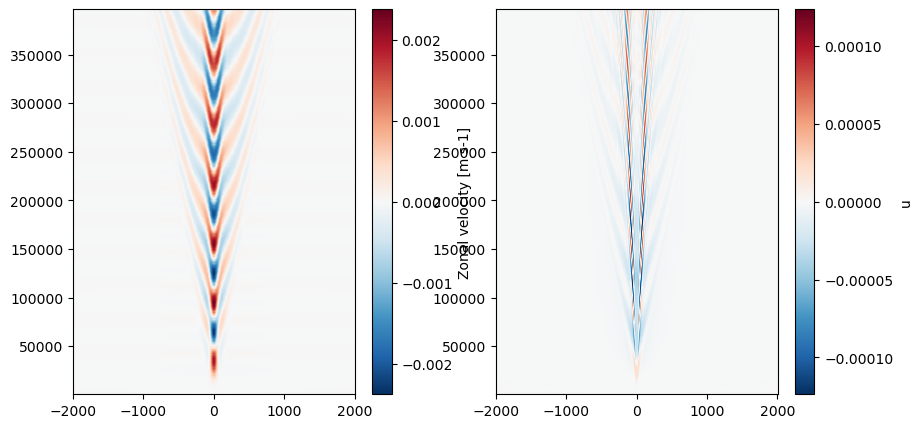

In [3]:

import matplotlib.pyplot as plt

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (10,5))

zonal_anom = zonal.u.sel(yh = 0,method = "nearest") - merid.u.sel(yh = 0,method = "nearest")

merid.u.isel(zl = 5).plot(ax=ax1)
zonal_anom.isel(zl = 5).plot(ax=ax2)

# Remove titles and axis labels
ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax2.set_title('')
ax2.set_xlabel('')
ax2.set_ylabel('')

# Display the plots
plt.show()

In [65]:
def groupspeed(n,N,L):
    f = 1e-4
    N = N * f
    k = 2 * np.pi / (L * 1000)
    H = 4000
    A = (n * np.pi / H)**2

    num = k * A * (N**2 - f**2) 
    den = np.sqrt(N**2 * k**2 + f**2 * A) * np.sqrt(k**2 + A)**3
    return num/den

def phasespeed(n,N,L):
    f = 1e-4
    N = N * f
    k = 2 * np.pi / (L * 1000)
    H = 4000
    A = (n * np.pi / H)**2

    num = np.sqrt(N**2 * k**2 + f**2 * A)
    den = k * np.sqrt(k**2 + A)
    return num/den

print(groupspeed(1,50,100),phasespeed(1,50,100))
print(groupspeed(1,20,50),phasespeed(1,20,50))


6.114852123903904 6.54122786723734
2.3342793230955263 2.634415576160961


In [32]:
N = 0.005
f = 1e-4
N / f

50.0

/jobfs/122559644.gadi-pbs/ipykernel_259006/2402139704.py:18: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  data_u = data.u.interp(xq = data_e.xh).drop("xq")


17.453292519943293
0 30
1 56


/jobfs/122559644.gadi-pbs/ipykernel_259006/2402139704.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i//2,i%2].set_yticklabels([4000,3000,2000,1000,0])


2 82
3 109


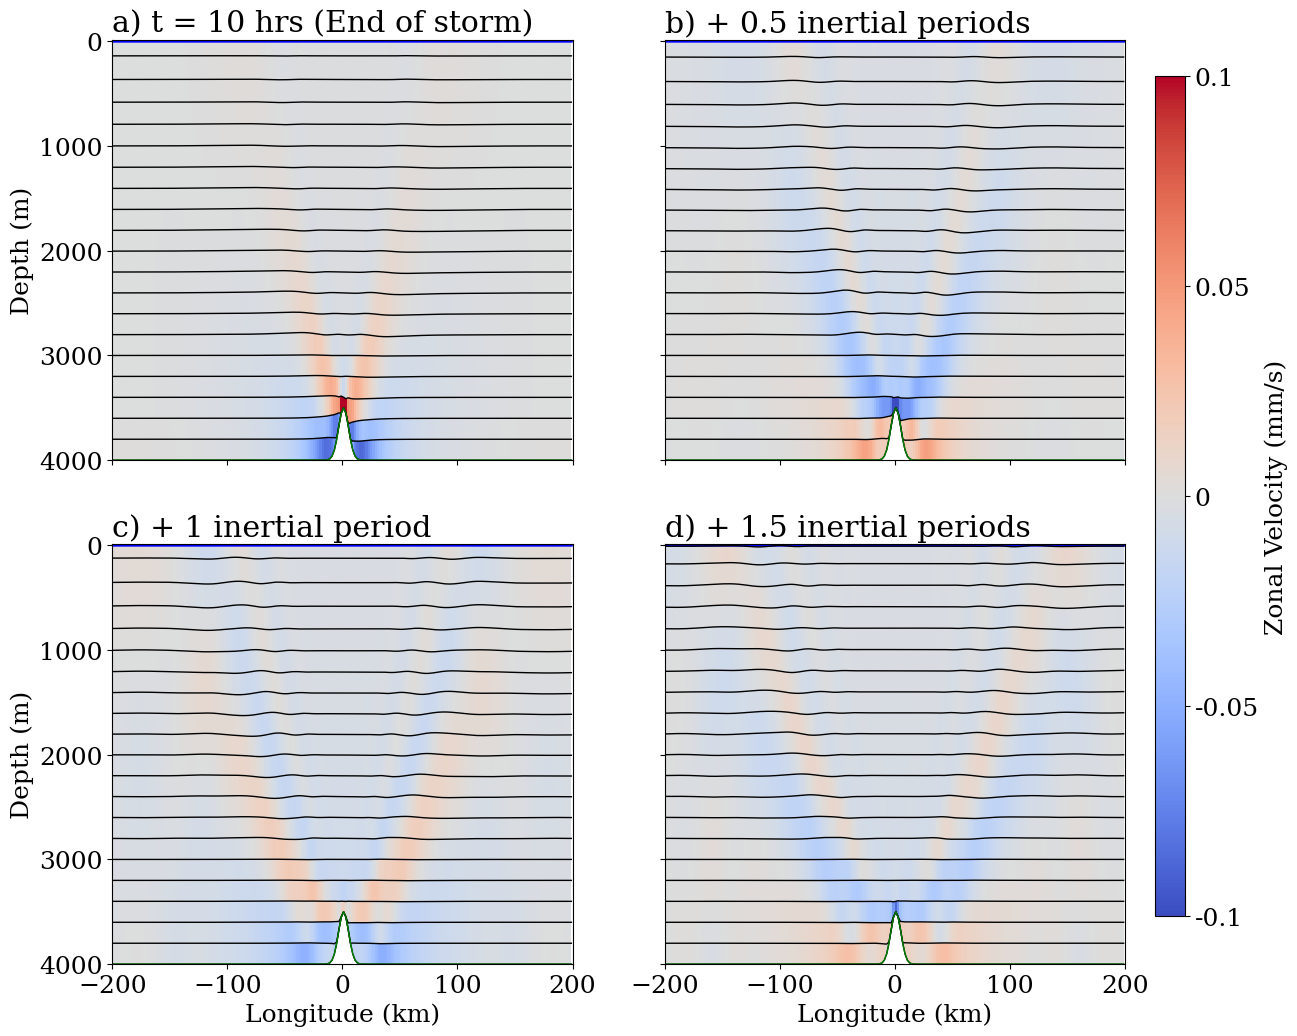

In [4]:
from matplotlib.gridspec import GridSpec
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib
font = {'family' : 'serif',
        'weight':'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
cmap = "coolwarm"
framedim = "time"
import seaborn as sns



data = xr.open_mfdataset("/home/149/ab8992/topographic-NIWs/outputdir/common_mixedlayer/zonal/*.nc",decode_times = False,decode_cf = False)

data_e = data.e
data_u = data.u.interp(xq = data_e.xh).drop("xq")

data_u = (data_u - data_u.mean("xh")).sel(xh = slice(-200,200))
data_e = data_e.sel(xh = slice(-200,200))
data_e = data_e.mean("yh").load()
data_u = data_u.mean("yh").load()



def snapshot(time,ax):
    tt = time
    vmax = data_u.isel(time = tt).max().values * 1
    vmax = 0.0004
    vmin = -1 * vmax
    scaling = 2000 # Scale the anomaly in interface height
    x = data_u.xh
    mean_depths = data_e.isel(time = 0)
    base = mean_depths.isel(zi = 0)
    deviation = (data_e.isel(time = tt).isel(zi = 0) - mean_depths[0,:])
    layer = base + deviation * scaling
    layer.plot(ax = ax,color = "blue",linewidth = 2)
  

    for i in range(0,21):
        prev_layer = layer
        if i == 10:
            scaling = 1500
        if i == 13:
            scaling = 1000
        if i == 15:
            scaling = 200
        ## Plot this layer 
        base = mean_depths.isel(zi = i+1)
        deviation = (data_e.isel(time = tt).isel(zi = i+1) - mean_depths.isel(zi = i+1))
        layer = base + deviation * scaling
        layer.plot(ax = ax,color = "black",linewidth = 1)


        # Create patch for the clipping of velocity field to fill space between layers. See https://matplotlib.org/stable/tutorials/advanced/path_tutorial.html
        
        # verts = np.vstack([np.stack([x, prev_layer], 1), np.stack([np.flip(x), np.flip(layer * 0 + 4000)], 1)]) ## creates vertices 
        verts = np.vstack([np.stack([x, prev_layer], 1), np.stack([np.flip(x), np.flip(layer)], 1)]) ## creates vertices 
        path = Path(verts)
        patch = PathPatch(path, lw = 2,transform=ax.transData) ## patch to clip the velocity field

        # Plot velocity field and apply patch as clip path
        velfield = data_u.isel(time = tt,zl = i).expand_dims({"vert":2},axis = 1)
        X,Y = np.meshgrid(np.linspace(x[0].values.reshape(1)[0],x[-1].values.reshape(1)[0],x.shape[0]),np.linspace(prev_layer.max().values.reshape(1)[0],layer.min().values.reshape(1)[0],2))
        im = ax.pcolormesh(X, Y, velfield.T,cmap = cmap,vmin = vmin,vmax = vmax)
        im.set_clip_path(patch)

    
    
    ## Handle bottom layer case
    prev_layer = layer
    layer = data_e.isel(time = 0,zi = -1)
    
    layer.plot(ax = ax,color = "green",linewidth = 1)
    
    verts = np.vstack([np.stack([x, layer], 1), np.stack([np.flip(x), np.flip(prev_layer)], 1)])
    path = Path(verts)
    
    patch = PathPatch(path, lw = 2,transform=ax.transData)
    
    # Plot bottom layer velocity
    velfield = data_u.isel(time = tt,zl = -1).expand_dims({"vert":2},axis = 1) 
    X,Y = np.meshgrid(np.linspace(x[0].values.reshape(1)[0],x[-1].values.reshape(1)[0],data_u.xh.shape[0]),np.linspace(prev_layer.max().values.reshape(1)[0],layer.min().values.reshape(1)[0],2))
    im = ax.pcolormesh(X, Y, velfield.T,cmap = cmap,vmin = vmin,vmax = vmax)
    im.set_clip_path(patch)
    ax = plt.gca()
    ax.set_ylim([-4000,10])


    
    return ax
    

fig,axes = plt.subplots(2,2,figsize = (15,12),sharey = True,sharex=True)


start = 10 # hours. Next convert to timesteps/ 3 per hour
start *= 3

## Get inertial period
fp = (2 * np.pi / 0.0001) / 3600
print(fp)
fp_10mins = fp * 3

captions = ["a) t = 10 hrs (End of storm)","b) + 0.5 inertial periods","c) + 1 inertial period","d) + 1.5 inertial periods"]

# for i,time in enumerate([30,60,120,180]):
for i,time in enumerate([start,start + round(fp_10mins * 0.5),start + round(fp_10mins * 1),start + round(fp_10mins * 1.5)]):
    print(i,time)
    snapshot(time,axes[i//2,i%2])
    axes[i//2,i%2].set_title("")

    axes[i//2,i%2].set_title(captions[i],loc = "left")


    axes[i//2,i%2].set_xlabel("Longitude (km)")
    axes[i//2,i%2].set_ylabel("Depth (m)")
    axes[i//2,i%2].set_yticklabels([4000,3000,2000,1000,0])
    axes[i//2,i%2].set_yticks([-4000,-3000,-2000,-1000,0])
    if i%2 != 0:
        axes[i//2,i%2].set_ylabel("")
    if i//2 != 1:
        axes[i//2,i%2].set_xlabel("")

    # break

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])

norm = matplotlib.colors.Normalize(vmin=-1e-1, vmax=1e-1)
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap="coolwarm"),cax = cbar_ax,label = f"Zonal Velocity (mm/s)")
cbar.set_ticks([-0.1,-0.05,0,0.05,0.1])
cbar.set_ticklabels([-0.1,-0.05,0,0.05,0.1])




In [12]:
ml = xr.open_mfdataset("/home/149/ab8992/topographic-NIWs/outputdir/common_mixedlayer/zonal/*.nc",decode_times = False,decode_cf = False).v
noml = xr.open_mfdataset("/home/149/ab8992/topographic-NIWs/outputdir/height_500/zonal/*.nc",decode_times = False,decode_cf = False).v

print(np.max(ml.isel(zl = -1)).values)
print(np.max(noml.isel(zl = -1)).values)

0.0005078028052862399
0.0010211628179714845


/jobfs/122559644.gadi-pbs/ipykernel_259006/3442127781.py:16: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  data_u = data.v.interp(yq = data_e.yh).drop("yq")


17.453292519943293
0 30
1 56


/jobfs/122559644.gadi-pbs/ipykernel_259006/3442127781.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i//2,i%2].set_yticklabels([4000,3000,2000,1000,0])


2 82
3 109


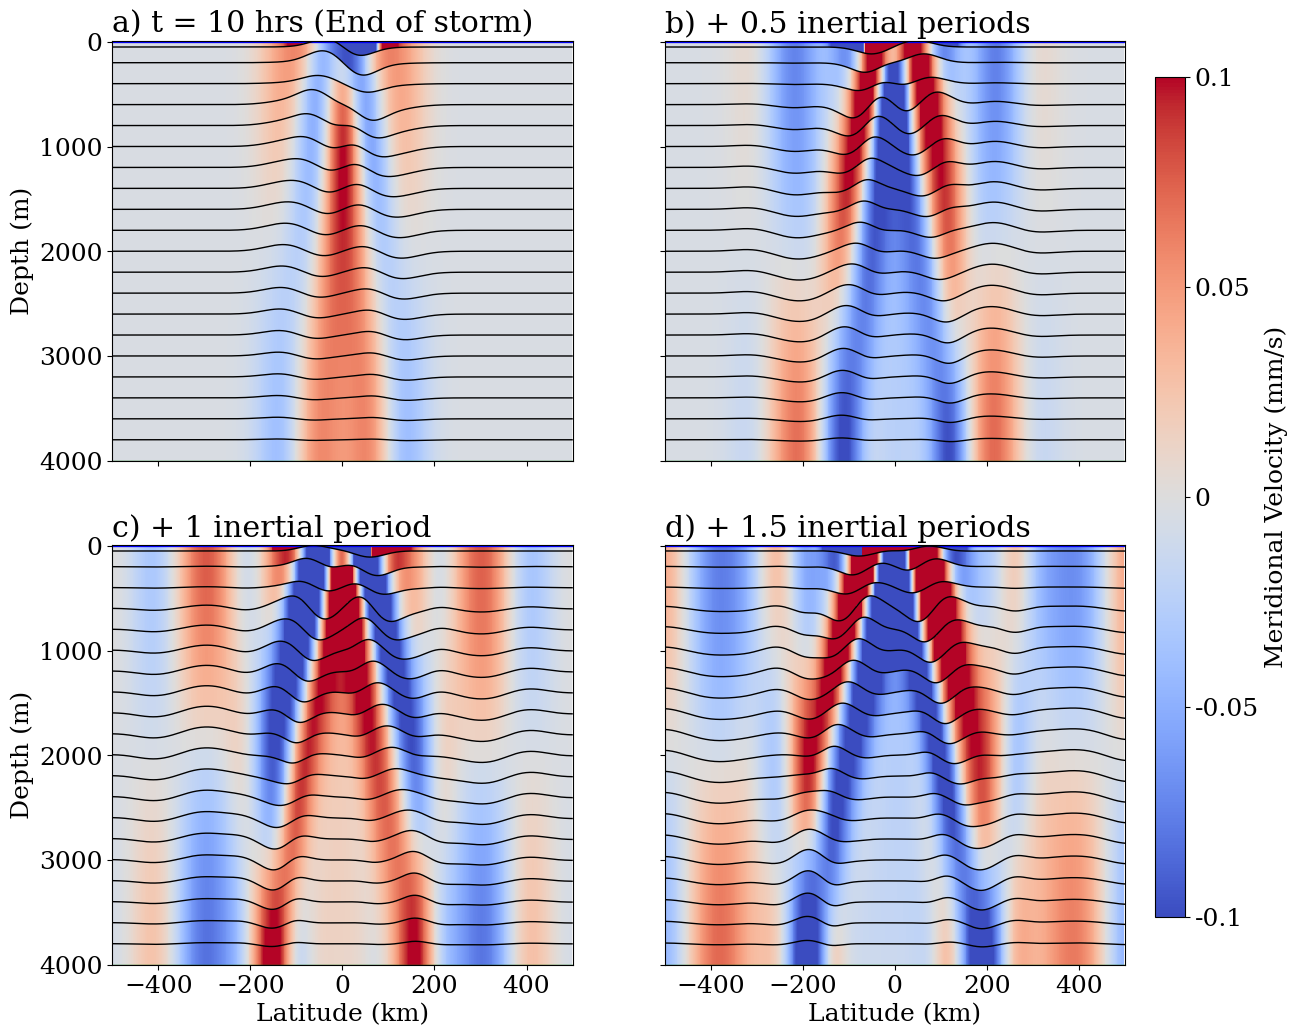

In [8]:
from matplotlib.gridspec import GridSpec
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib
font = {'family' : 'serif',
        'weight':'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
cmap = "coolwarm"
framedim = "time"
import seaborn as sns

data = xr.open_mfdataset("/home/149/ab8992/topographic-NIWs/outputdir/common_mixedlayer/merid/*.nc",decode_times = False,decode_cf = False)

data_e = data.e
data_u = data.v.interp(yq = data_e.yh).drop("yq")

# data_u = (data_u - data_u.mean("xh")).sel(yh = slice(-200,200))
data_e = data_e.sel(yh = slice(-500,500))
data_u = data_u.sel(yh = slice(-500,500))
data_e = data_e.mean("xh").load()
data_u = data_u.mean("xh").load()

data_u = data_u.rename({"yh":"xh"})
data_e = data_e.rename({"yh":"xh"})


def snapshot(time,ax):
    tt = time
    vmax = data_u.isel(time = tt).max().values * 1
    vmax = 0.001
    vmin = -1 * vmax
    scaling = 100 # Scale the anomaly in interface height
    x = data_u.xh
    mean_depths = data_e.isel(time = 0)
    base = mean_depths.isel(zi = 0)
    deviation = (data_e.isel(time = tt).isel(zi = 0) - mean_depths[0,:])
    layer = base + deviation * scaling
    layer.plot(ax = ax,color = "blue",linewidth = 2)
  

    for i in range(0,20):
        prev_layer = layer
        if i == 1:
            scaling = 200
        if i == 3:
            scaling = 500
        # if i == 13:
        #     scaling = 1000
        # if i == 15:
        #     scaling = 200
        ## Plot this layer 
        base = mean_depths.isel(zi = i+1)
        deviation = (data_e.isel(time = tt).isel(zi = i+1) - mean_depths.isel(zi = i+1))
        layer = base + deviation * scaling
        layer.plot(ax = ax,color = "black",linewidth = 1)


        # Create patch for the clipping of velocity field to fill space between layers. See https://matplotlib.org/stable/tutorials/advanced/path_tutorial.html
        
        # verts = np.vstack([np.stack([x, prev_layer], 1), np.stack([np.flip(x), np.flip(layer * 0 + 4000)], 1)]) ## creates vertices 
        verts = np.vstack([np.stack([x, prev_layer], 1), np.stack([np.flip(x), np.flip(layer)], 1)]) ## creates vertices 
        path = Path(verts)
        patch = PathPatch(path, lw = 2,transform=ax.transData) ## patch to clip the velocity field

        # Plot velocity field and apply patch as clip path
        velfield = data_u.isel(time = tt,zl = i).expand_dims({"vert":2},axis = 1)
        X,Y = np.meshgrid(np.linspace(x[0].values.reshape(1)[0],x[-1].values.reshape(1)[0],x.shape[0]),np.linspace(prev_layer.max().values.reshape(1)[0],layer.min().values.reshape(1)[0],2))
        im = ax.pcolormesh(X, Y, velfield.T,cmap = cmap,vmin = vmin,vmax = vmax)
        im.set_clip_path(patch)

    
    
    ## Handle bottom layer case
    prev_layer = layer
    layer = data_e.isel(time = 0,zi = -1)
    
    layer.plot(ax = ax,color = "green",linewidth = 1)
    
    verts = np.vstack([np.stack([x, layer], 1), np.stack([np.flip(x), np.flip(prev_layer)], 1)])
    path = Path(verts)
    
    patch = PathPatch(path, lw = 2,transform=ax.transData)
    
    # Plot bottom layer velocity
    velfield = data_u.isel(time = tt,zl = -1).expand_dims({"vert":2},axis = 1) 
    X,Y = np.meshgrid(np.linspace(x[0].values.reshape(1)[0],x[-1].values.reshape(1)[0],data_u.xh.shape[0]),np.linspace(prev_layer.max().values.reshape(1)[0],layer.min().values.reshape(1)[0],2))
    im = ax.pcolormesh(X, Y, velfield.T,cmap = cmap,vmin = vmin,vmax = vmax)
    im.set_clip_path(patch)
    ax = plt.gca()
    ax.set_ylim([-4000,10])


    
    return ax
    

fig,axes = plt.subplots(2,2,figsize = (15,12),sharey = True,sharex=True)


start = 10 # hours. Next convert to timesteps/ 3 per hour
start *= 3

## Get inertial period
fp = (2 * np.pi / 0.0001) / 3600
print(fp)
fp_10mins = fp * 3

captions = ["a) t = 10 hrs (End of storm)","b) + 0.5 inertial periods","c) + 1 inertial period","d) + 1.5 inertial periods"]

# for i,time in enumerate([30,60,120,180]):
for i,time in enumerate([start,start + round(fp_10mins * 0.5),start + round(fp_10mins * 1),start + round(fp_10mins * 1.5)]):
    print(i,time)
    snapshot(time,axes[i//2,i%2])
    axes[i//2,i%2].set_title("")

    axes[i//2,i%2].set_title(captions[i],loc = "left")


    axes[i//2,i%2].set_xlabel("Latitude (km)")
    axes[i//2,i%2].set_ylabel("Depth (m)")
    axes[i//2,i%2].set_yticklabels([4000,3000,2000,1000,0])
    axes[i//2,i%2].set_yticks([-4000,-3000,-2000,-1000,0])
    if i%2 != 0:
        axes[i//2,i%2].set_ylabel("")
    if i//2 != 1:
        axes[i//2,i%2].set_xlabel("")

    # break

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])

norm = matplotlib.colors.Normalize(vmin=-1e-1, vmax=1e-1)
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap="coolwarm"),cax = cbar_ax,label = f"Meridional Velocity (mm/s)")
cbar.set_ticks([-0.1,-0.05,0,0.05,0.1])
cbar.set_ticklabels([-0.1,-0.05,0,0.05,0.1])




In [39]:
a = 0

for i in range(len(data_u.time)):
    if np.max(data_u.isel(time = i).values) > a:
        a = np.max(data_u.isel(time = i).values)
        print(i,a)
    # print(i,np.max(data_u.isel(time = i).values))
# np.max(data_u)

0 3.2872680456993897e-09
1 3.627479376950261e-08
2 1.428875478699018e-07
3 3.800153754261043e-07
4 8.038043111485878e-07
5 1.4087466660439752e-06
6 2.6712485707699307e-06
7 5.89968867334352e-06
8 1.3169652727857933e-05
9 2.6046766863023486e-05
10 4.5725902946827036e-05
11 7.375334830423766e-05
12 0.00011142223867136142
13 0.00015966101049625885
14 0.0002189347563514403
15 0.0002891891974324204
16 0.0003699278185273467
17 0.0004602597716094782
18 0.0005587980245798212
19 0.0006636003333778143
20 0.000772173970073107
21 0.0008815248763641686
22 0.000988233133035713
23 0.0010885607032560154
24 0.0011786103077603223
25 0.0012545171174829436
26 0.0013126614112567627
27 0.0013498796791999658
28 0.0013636488602550047


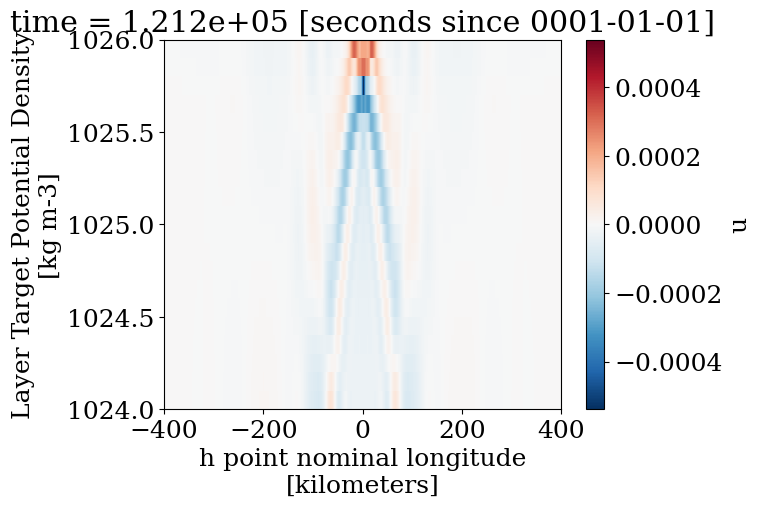

In [61]:
data_u.isel(time = 100).plot()